In [65]:
import os
import numpy as np
import pandas as pd
import sklearn.linear_model as sklm
import sklearn.model_selection as skms
import sklearn.feature_selection
import sklearn.pipeline
from sklearn.utils import shuffle
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt

# Import our filess
from load_train_data import load_data 


In [66]:
website_list, review_list, rating_list = load_data('x_train.csv', 'y_train.csv')

In [67]:
# Create a logistic regression classifier
logistic = sklm.LogisticRegression(solver='liblinear')
# Hyperparameters distributions - regularization strength C (10E-4 to 10E6, originally 10E-9 to 10E6),
# penalty (L1, L2), max iterations (80 to 100, originally 1 to 50000)
distributions = dict(C=np.logspace(-2,2,200), penalty = ['l2', 'l1'], max_iter = 
                     np.logspace(np.log10(80),np.log10(200),50, dtype=int)) 
# Number of folds for cross validation
numFolds = 5

#Pipeline starts!
my_bow_classifier_pipeline = sklearn.pipeline.Pipeline([
    ('my_bow_feature_extractor', CountVectorizer(min_df=2, max_df=1.0, ngram_range=(1,1))),
    ('cross validation', skms.RandomizedSearchCV(logistic, distributions, n_iter=200, cv=numFolds, verbose=0, random_state=0, error_score='raise',
                                                  scoring='roc_auc', return_train_score=True))
])

my_bow_classifier_pipeline.fit(review_list, rating_list)
# my_bow_classifier_pipeline.predict(review_list)
# my_bow_classifier_pipeline.score(review_list, rating_list)
probs = my_bow_classifier_pipeline.predict_proba(review_list)


c:\Users\avtar\micromambaenv\envs\cs135_env\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [68]:
#Get useful data out from the random search
optParams = my_bow_classifier_pipeline['cross validation'].best_params_
print('Best parameters: ', optParams)
# This final logistic regression classifier is the best estimator from the random search, 
# and used the chosen hyperparameters (optParams) and the entire training set.
finalEstimator = my_bow_classifier_pipeline.named_steps['cross validation'].best_estimator_


# my_bow_classifier_pipeline.named_steps['cross validation'].cv_results_

# cvKeys = list(cvRes.keys())
# print(type(cvKeys))
# print(cvRes['rank_test_score'])

# gsearch_results_df = pd.DataFrame(cvRes).copy()
# param_keys = cvKeys

# # Rearrange row order so it is easy to skim
# gsearch_results_df.sort_values(param_keys, inplace=True)

Best parameters:  {'penalty': 'l2', 'max_iter': 98, 'C': 1.7027691722258995}


In [69]:
weights = my_bow_classifier_pipeline['cross validation'].best_estimator_.coef_

#getting CountVectorizer dictionary
dictionary = my_bow_classifier_pipeline['my_bow_feature_extractor'].vocabulary_

print(my_bow_classifier_pipeline['cross validation'].best_params_)

acc = roc_auc_score(rating_list, probs[:,1])
print("AUROC on full Training set: %.3f" % acc)

ResultsCV = my_bow_classifier_pipeline['cross validation'].cv_results_
optIter = my_bow_classifier_pipeline['cross validation'].best_index_
Res_Train = ResultsCV['mean_train_score'][optIter]
Res_Val = ResultsCV['mean_test_score'][optIter]

print("AUROC on Training folds: %.4f" % Res_Train)
print("AUROC on Heldout folds: %.4f" % Res_Val)
print('Length of vocabulary is %i' % len(dictionary))

{'penalty': 'l2', 'max_iter': 98, 'C': 1.7027691722258995}
AUROC on full Training set: 0.993
AUROC on Training folds: 0.9941
AUROC on Heldout folds: 0.8734
Length of vocabulary is 1912


# Determining optimum df values
min_df = 1, max_df = 0.08
```python
{'penalty': 'l2', 'max_iter': 79, 'C': 1.1226677735108135}
AUROC on full Training set: 0.994
AUROC on Training folds: 0.9952
AUROC on Heldout folds: 0.8606
```

min_df = 1, max_df = 1.0
```python
{'penalty': 'l2', 'max_iter': 94, 'C': 1.7834308769319094}
AUROC on full Training set: 0.997
AUROC on Training folds: 0.9981
AUROC on Heldout folds: 0.8727
```

min_df = 2, max_df = 1.0
```python
{'penalty': 'l2', 'max_iter': 98, 'C': 1.7027691722258995}
AUROC on full Training set: 0.993
AUROC on Training folds: 0.9941
AUROC on Heldout folds: 0.8734
```

min_df = 3, max_df = 1.0
```python
{'penalty': 'l2', 'max_iter': 120, 'C': 0.890735463861044}
AUROC on full Training set: 0.979
AUROC on Training folds: 0.9822
AUROC on Heldout folds: 0.8676
```

In [70]:
yhat = my_bow_classifier_pipeline.predict(review_list)
yhatProbs = my_bow_classifier_pipeline.predict_proba(review_list)
print(yhat)

for revIdx in np.arange(len(yhat)):
    if yhat[revIdx] != rating_list[revIdx]:
        print('True %s|%s Pred| %1.3f| %s' % (rating_list[revIdx], yhat[revIdx], yhatProbs[revIdx][1], review_list[revIdx]))

[0 0 0 ... 1 1 1]
True 0|1 Pred| 0.656| I really wanted the Plantronics 510 to be the right one, but it has too many issues for me.The good
True 0|1 Pred| 0.849| Excellent starter wireless headset.
True 0|1 Pred| 0.543| The commercials are the most misleading.
True 0|1 Pred| 0.946| The loudspeaker option is great, the bumpers with the lights is very ... appealing.
True 0|1 Pred| 0.585| Very Dissapointing Performance.
True 0|1 Pred| 0.604| Not good enough for the price.
True 1|0 Pred| 0.443| I really like this product over the Motorola because it is allot clearer on the ear piece and the mic.
True 1|0 Pred| 0.476| I had absolutely no problem with this headset linking to my 8530 Blackberry Curve!
True 1|0 Pred| 0.438| Its a total package.
True 1|0 Pred| 0.467| Very satisifed with that.
True 1|0 Pred| 0.424| Just what I wanted.
True 0|1 Pred| 0.823| Graphics is far from the best part of the game.  
True 0|1 Pred| 0.518| It is not good.  
True 0|1 Pred| 0.617| Highly unrecommended.  
True 

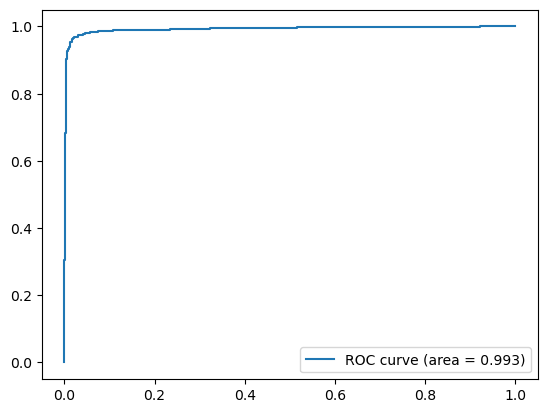

In [71]:
fpr, tpr, thresh = roc_curve(rating_list, probs[:,1])

plt.plot(fpr, tpr, label = 'ROC curve (area = %0.3f)' % acc)
plt.legend()

In [72]:
# Load test data
x_te_data = 'x_test.csv'
data_dir = 'data_reviews'
x_te_df = pd.read_csv(os.path.join(data_dir, x_te_data))
te_website_list = x_te_df['website_name'].values.tolist()
te_text_list = x_te_df['text'].values.tolist()

probs = my_bow_classifier_pipeline.predict_proba(te_text_list)[:, 1]
print(probs.shape)

# Save predictions to file (need to rename for upload)
np.savetxt('q1.txt', probs, fmt='%s')


(600,)


# Evaluate impact of each hyperparameter, using "best" parameters for all others.

In [73]:
### Evaluate C!

# Create a logistic regression classifier
logisticEvalHype = sklm.LogisticRegression(solver='liblinear',penalty=optParams['penalty'], max_iter=optParams['max_iter'])
# Hyperparameters distributions - regularization strength C
numFolds = 5
CDist = np.logspace(-9,6,40)
distEvalHype = dict(C = CDist) #[10**(-4), optParams['C'], 10**6])

#Pipeline starts!
evalHypeParamCPipe = sklearn.pipeline.Pipeline([
    ('my_bow_feature_extractor', CountVectorizer(min_df=1, max_df=0.08, ngram_range=(1,1))),
    ('cross validation', skms.GridSearchCV(logisticEvalHype, distEvalHype, cv=numFolds, verbose=0, 
                                                error_score='raise', scoring='roc_auc', return_train_score=True))
])

# (shuffleReviews, shuffledRatings) = shuffle(review_list, rating_list, random_state=0)
# evalHypeParamCPipe.fit(shuffleReviews, shuffledRatings)
evalHypeParamCPipe.fit(review_list, rating_list)

Pipeline(steps=[('my_bow_feature_extractor', CountVectorizer(max_df=0.08)),
                ('cross validation',
                 GridSearchCV(cv=5, error_score='raise',
                              estimator=LogisticRegression(max_iter=98,
                                                           solver='liblinear'),
                              param_grid={'C': array([1.00000000e-09, 2.42446202e-09, 5.87801607e-09, 1.42510267e-08,
       3.45510729e-08, 8.37677640e-08, 2.03091762e-07, 4.92388263e-07,
       1.19377664e-06,...
       1.42510267e-03, 3.45510729e-03, 8.37677640e-03, 2.03091762e-02,
       4.92388263e-02, 1.19377664e-01, 2.89426612e-01, 7.01703829e-01,
       1.70125428e+00, 4.12462638e+00, 1.00000000e+01, 2.42446202e+01,
       5.87801607e+01, 1.42510267e+02, 3.45510729e+02, 8.37677640e+02,
       2.03091762e+03, 4.92388263e+03, 1.19377664e+04, 2.89426612e+04,
       7.01703829e+04, 1.70125428e+05, 4.12462638e+05, 1.00000000e+06])},
                              return_train_score=True, scoring='roc_auc'))])

In [74]:
### Evaluate max_iter!

# Create a logistic regression classifier
logisticEvalHype = sklm.LogisticRegression(solver='liblinear',penalty=optParams['penalty'], C=optParams['C'])
# Hyperparameters distributions - regularization strength C
maxIterDist = np.logspace(np.log10(1),np.log10(50000),50, dtype=int)
distEvalHype = dict(max_iter = maxIterDist) 

#Pipeline starts!
evalHypeParamIterPipe = sklearn.pipeline.Pipeline([
    ('my_bow_feature_extractor', CountVectorizer(min_df=1, max_df=0.08, ngram_range=(1,1))),
    ('cross validation', skms.GridSearchCV(logisticEvalHype, distEvalHype, cv=5, verbose=0, 
                                                error_score='raise', scoring='roc_auc', return_train_score=True))
])


# Shuffle data
# (shuffleReviews, shuffledRatings) = shuffle(review_list, rating_list, random_state=0)
# evalHypeParamIterPipe.fit(shuffleReviews, shuffledRatings)
evalHypeParamIterPipe.fit(review_list, rating_list)

c:\Users\avtar\micromambaenv\envs\cs135_env\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\avtar\micromambaenv\envs\cs135_env\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\avtar\micromambaenv\envs\cs135_env\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\avtar\micromambaenv\envs\cs135_env\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\avtar\micromambaenv\envs\cs135_env\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\avtar\micromambaenv\envs\cs135_env\l

Pipeline(steps=[('my_bow_feature_extractor', CountVectorizer(max_df=0.08)),
                ('cross validation',
                 GridSearchCV(cv=5, error_score='raise',
                              estimator=LogisticRegression(C=1.7027691722258995,
                                                           solver='liblinear'),
                              param_grid={'max_iter': array([    1,     1,     1,     1,     2,     3,     3,     4,     5,
           7,     9,    11,    14,    17,    22,    27,    34,    42,
          53,    66,    82,   103,   128,   160,   200,   249,   311,
         388,   484,   603,   753,   939,  1171,  1460,  1821,  2271,
        2833,  3533,  4406,  5495,  6853,  8546, 10658, 13291, 16576,
       20671, 25779, 32149, 40093, 49999])},
                              return_train_score=True, scoring='roc_auc'))])

(5, 40)


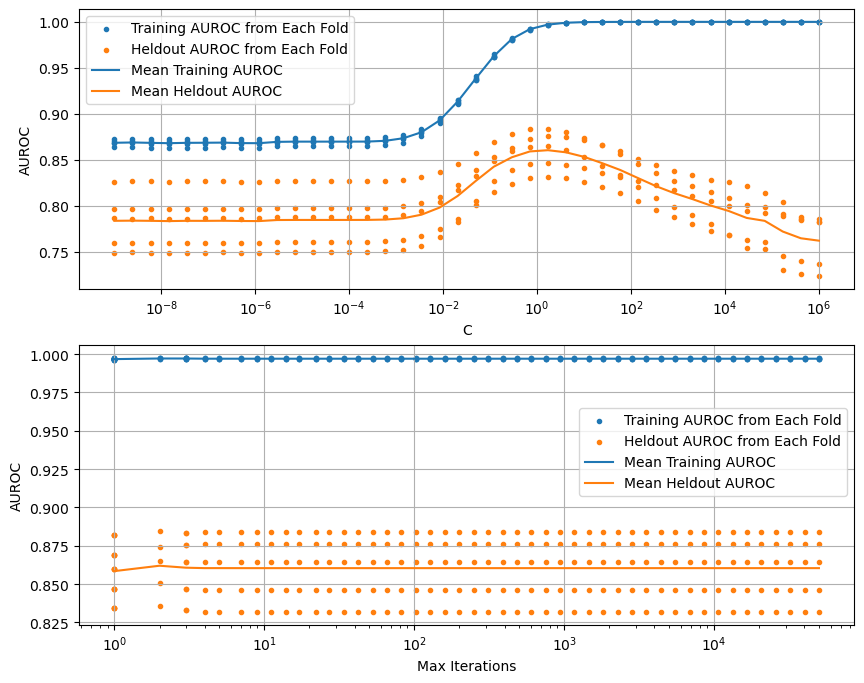

In [75]:
# Extract C data for plotting

CVars = evalHypeParamCPipe['cross validation'].cv_results_

C_Train = CVars['mean_train_score']
C_Val = CVars['mean_test_score']
C_TrainFolds = np.vstack((CVars['split0_train_score'], CVars['split1_train_score'], CVars['split2_train_score'], CVars['split3_train_score'], CVars['split4_train_score']))
C_ValFolds = np.vstack((CVars['split0_test_score'], CVars['split1_test_score'], CVars['split2_test_score'], CVars['split3_test_score'], CVars['split4_test_score']))
CDistFolds = np.tile(CDist, (numFolds,1))
print(CDistFolds.shape)

# Extract max_iter data for plotting
IterVars = evalHypeParamIterPipe['cross validation'].cv_results_

Iter_Train = IterVars['mean_train_score']
Iter_Val = IterVars['mean_test_score']
Iter_TrainFolds = np.vstack((IterVars['split0_train_score'], IterVars['split1_train_score'], IterVars['split2_train_score'], IterVars['split3_train_score'], IterVars['split4_train_score']))
Iter_ValFolds = np.vstack((IterVars['split0_test_score'], IterVars['split1_test_score'], IterVars['split2_test_score'], IterVars['split3_test_score'], IterVars['split4_test_score']))
IterDistFolds = np.tile(maxIterDist, (numFolds,1))

# Plot accuracy vs C and max_iter hyperparameters

fig, (ax1, ax2) = plt.subplots(2,1, figsize=(10,8))
ax1.scatter(CDistFolds, C_TrainFolds, label='Training AUROC from Each Fold',marker='.')
ax1.scatter(CDistFolds, C_ValFolds, label='Heldout AUROC from Each Fold',marker='.')
ax1.plot(CDist, C_Train, label='Mean Training AUROC')
ax1.plot(CDist, C_Val, label='Mean Heldout AUROC')
ax1.legend()
ax1.set_xlabel('C')
ax1.set_ylabel('AUROC')
ax1.set_xscale('log')
ax1.grid(which='both')

# fig, ax = plt.subplots()
ax2.scatter(IterDistFolds, Iter_TrainFolds, label='Training AUROC from Each Fold',marker='.')
ax2.scatter(IterDistFolds, Iter_ValFolds, label='Heldout AUROC from Each Fold',marker='.')
ax2.plot(maxIterDist, Iter_Train, label='Mean Training AUROC')
ax2.plot(maxIterDist, Iter_Val, label='Mean Heldout AUROC')
ax2.legend(loc='upper right', bbox_to_anchor=(1, 0.8))
ax2.set_xlabel('Max Iterations')
ax2.set_ylabel('AUROC')
ax2.set_xscale('log')
ax2.grid(which='major')